Computing for g = 0.500 ...
  I_e=1.821378e-01, I_m=1.656371e-01, ratio_I=0.9094; energy_ratio=1.0399
Computing for g = 1.000 ...
  I_e=3.458483e-01, I_m=2.381997e-01, ratio_I=0.6887; energy_ratio=0.7901
Computing for g = 1.500 ...
  I_e=5.982693e-01, I_m=3.287720e-01, ratio_I=0.5495; energy_ratio=0.6168
Computing for g = 2.000 ...
  I_e=9.830835e-01, I_m=4.412925e-01, ratio_I=0.4489; energy_ratio=0.4905
Computing for g = 2.500 ...
  I_e=1.528411e+00, I_m=5.790405e-01, ratio_I=0.3789; energy_ratio=0.4041
Computing for g = 3.000 ...
  I_e=2.226688e+00, I_m=7.441862e-01, ratio_I=0.3342; energy_ratio=0.3499
Computing for g = 3.500 ...
  I_e=3.054357e+00, I_m=9.378124e-01, ratio_I=0.3070; energy_ratio=0.3173
Computing for g = 4.000 ...
  I_e=4.000873e+00, I_m=1.160334e+00, ratio_I=0.2900; energy_ratio=0.2971
Computing for g = 4.500 ...
  I_e=5.068039e+00, I_m=1.411996e+00, ratio_I=0.2786; energy_ratio=0.2836
Computing for g = 5.000 ...
  I_e=6.259270e+00, I_m=1.693199e+00, ratio_I=0.2705; 

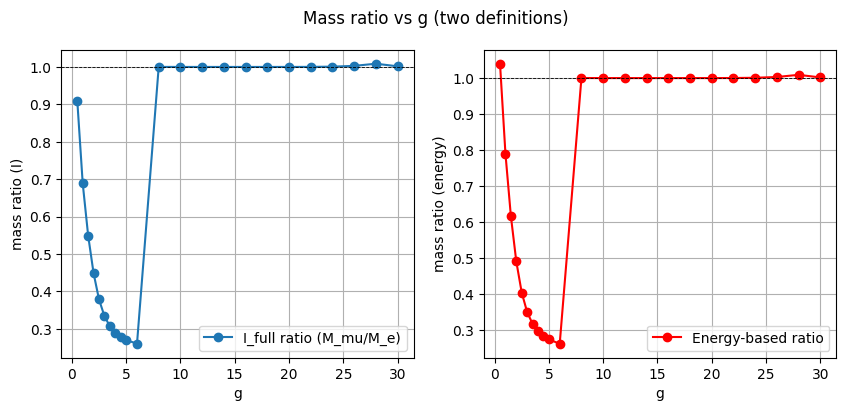

g where I_full ratio >1: [ 8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
g where energy ratio >1: [ 0.5  8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30. ]


In [ ]:
# Sweep g — porównanie definicji masy i wyszukanie, gdzie M_mu > M_e
import numpy as np
import matplotlib.pyplot as plt

# --- Parametry numeryczne (dopasuj do twojego środowiska) ---
Nx = 2048
x_min, x_max = -40.0, 40.0
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]
N_target = 1.0
dtau = 5e-4

# Użyj tych samych funkcji z notebooka (skopiuj definicje, jeśli uruchamiasz oddzielnie)
def d_dx_centered(f, dx):
    df = np.zeros_like(f)
    df[1:-1] = (f[2:] - f[:-2]) / (2 * dx)
    return df

def d2_dx2_dirichlet(f, dx):
    f2 = np.zeros_like(f)
    f2[1:-1] = (f[2:] - 2*f[1:-1] + f[:-2]) / dx**2
    return f2

def normalize_L2(phi, dx, N_target=1.0):
    norm = np.sqrt(np.sum(phi**2) * dx)
    if norm < 1e-16: return phi
    return phi * (N_target / norm)

def energy_NLS(phi, dx, g):
    phi_prime = d_dx_centered(phi, dx)
    E_kin = 0.5 * np.sum(phi_prime**2) * dx
    E_nonlin = - (g/4.0) * np.sum(phi**4) * dx
    return E_kin, E_nonlin

def imag_time_step(phi, dx, dtau, g):
    lap = d2_dx2_dirichlet(phi, dx)
    phi_new = phi + dtau * (0.5 * lap + g * phi**3)
    return phi_new

# Funkcja budująca stany (ground + first excited) dla danego g
def compute_states_for_g(g, n_steps_e=30000, n_steps_m=50000):
    # ground init
    phi_e = np.exp(-x**2 / 4.0)
    phi_e = normalize_L2(phi_e, dx, N_target)
    for step in range(n_steps_e):
        phi_e = imag_time_step(phi_e, dx, dtau, g)
        phi_e = normalize_L2(phi_e, dx, N_target)
    # excited init (antysym)
    phi_m = 2.0 * x * np.exp(-x**2 / 8.0)
    phi_m = phi_m - np.sum(phi_m * phi_e) * dx * phi_e
    phi_m = normalize_L2(phi_m, dx, N_target)
    for step in range(n_steps_m):
        phi_m = imag_time_step(phi_m, dx, dtau, g)
        proj = np.sum(phi_m * phi_e) * dx
        phi_m -= proj * phi_e
        phi_m = normalize_L2(phi_m, dx, N_target)
    return phi_e, phi_m

# Definicje mas / miar
def I_full(phi, dx, g):  # twoja obecna: gradient + g * phi^4
    phi_prime = d_dx_centered(phi, dx)
    return np.sum((phi_prime**2 + g * phi**4)) * dx

def M_energy(phi, dx, g): # alternatywna: energia kin + abs(energia nonlin)
    E_kin, E_nonlin = energy_NLS(phi, dx, g)
    return E_kin + abs(E_nonlin)

# --- siatka g do przeszukania ---
g_values = np.concatenate((np.linspace(0.5, 5.0, 10), np.linspace(6, 30, 13)))  # rozszerzony zakres
mass_ratio_I = []
mass_ratio_E = []

# UWAGA: ta pętla może być kosztowna obliczeniowo — zmniejsz n_steps_* jeśli chcesz szybko testować
for g_val in g_values:
    print(f"Computing for g = {g_val:.3f} ...")
    phi_e, phi_m = compute_states_for_g(g_val, n_steps_e=10000, n_steps_m=20000)  # skrócone kroki dla szybkości
    I_e = I_full(phi_e, dx, g_val)
    I_m = I_full(phi_m, dx, g_val)
    mass_ratio_I.append(I_m / I_e if I_e != 0 else np.nan)
    ME_e = M_energy(phi_e, dx, g_val)
    ME_m = M_energy(phi_m, dx, g_val)
    mass_ratio_E.append(ME_m / ME_e if ME_e != 0 else np.nan)
    print(f"  I_e={I_e:.6e}, I_m={I_m:.6e}, ratio_I={mass_ratio_I[-1]:.4f}; energy_ratio={mass_ratio_E[-1]:.4f}")

# Wykresy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(g_values, mass_ratio_I, 'o-', label='I_full ratio (M_mu/M_e)')
plt.axhline(1.0, color='k', lw=0.6, ls='--')
plt.xlabel('g'); plt.ylabel('mass ratio (I)'); plt.grid(True); plt.legend()
plt.subplot(1,2,2)
plt.plot(g_values, mass_ratio_E, 'o-r', label='Energy-based ratio')
plt.axhline(1.0, color='k', lw=0.6, ls='--')
plt.xlabel('g'); plt.ylabel('mass ratio (energy)'); plt.grid(True); plt.legend()
plt.suptitle('Mass ratio vs g (two definitions)')
plt.show()

# Znajdź przybliżone progi
g_where_I_over = g_values[np.where(np.array(mass_ratio_I) > 1.0)] if np.any(np.array(mass_ratio_I) > 1.0) else []
g_where_E_over = g_values[np.where(np.array(mass_ratio_E) > 1.0)] if np.any(np.array(mass_ratio_E) > 1.0) else []
print("g where I_full ratio >1:", g_where_I_over)
print("g where energy ratio >1:", g_where_E_over)
